# Training Generative Adversarial Networks (GAN's) in PyTorch

## Introducing to Generative Modelling

Deep neural networks are used mainly for supervised learning: Classification of regression. Generative Adversarial Networks or GAN's, however, use neural networks for a very different purpose: Generative modelling

```Generative modelling is an unsupervised learning task in machine learning that involves automatically discovering and learning the regualrities or patterns in input data in such a way that the model can be used to generate or output new examples that possibly could have been drawn from the original dataset. ```

There are two neural networks : a Generator and a Discriminator. The generator generates a 'Fake' sample given a random vector/matrix, and the discriminator attempts to detect whether a given sample is 'real' (picked from the training data) or 'fake' (generated by the generator). Training happens in tandem: we train the discriminator for few epochs, then train the generator for a few epochs, and repeat. This way both the generator and the discriminator get better at doing their jobs.

GAN's however, can be notoriously difficult to train, and are extremely sensitive to hyperparameters, activation functions and regularization. 

Let's load the dataset using the `ImageFolder` class from `torchvision`. We will also resize and crop the images to 64x64 px, and normalize the pixel values with a mean and standard deviation of 0.5 for each channel. This will ensure that pixel values are in the range `(-1,1)`, which is more convenient for training the discriminator. We will also create a data loader to load the data in batches.

importing libraries


In [27]:
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
import torch.nn as nn
import torch.nn.functional as F
from torchvision.utils import make_grid,save_image
import cv2
import os
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

%matplotlib inline

In [2]:
image_size = 64
batch_size = 128
stats = (0.5,0.5,0.5),(0.5,0.5,0.5)

In [3]:
transforms = T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)
])

In [4]:
train_ds = ImageFolder("data/anime_faces/",transform=transforms)
train_dl = DataLoader(train_ds, batch_size,shuffle=True, num_workers=4, pin_memory=True)

Let's create a helper function to denormalize the image tensor and display some sample images from a training batch.

In [5]:
def denorm(img_tensor):
    return img_tensor * stats[1][0] + stats[0][0]

In [6]:
def show_images(images, nmax=64):
    _,ax = plt.subplots(figsize=(8,8))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]),nrow=8).permute(1,2,0))

def show_batch(dl, nmax=64):
    for images,_ in dl:
        show_images(images,nmax)
        break

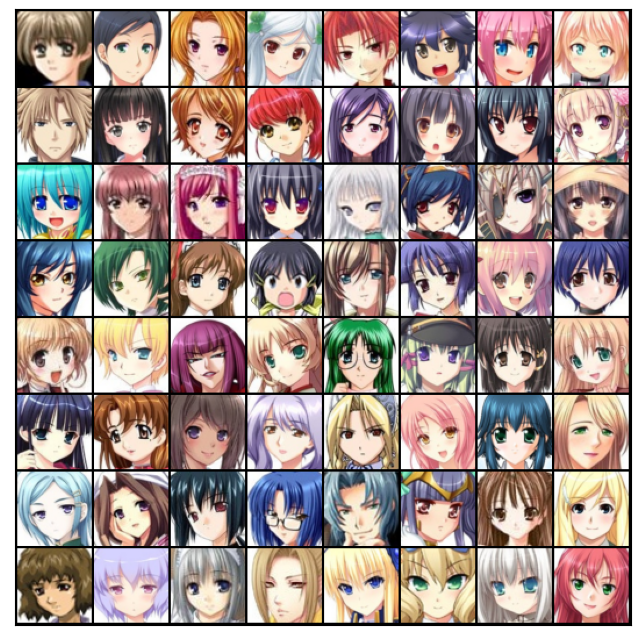

In [7]:
show_batch(train_dl)

## Using a GPU

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [9]:
def to_device(data,device):
    if isinstance(data,(tuple, list)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking = True)

In [10]:
class DeviceDataLoader():
    def __init__(self,dl, device):
        self.dl = dl 
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [11]:
train_dl = DeviceDataLoader(train_dl, device)

## Discriminator Network

The discriminator takes an image as input and tries to classify it as "real" or "generated". In this sense. it's like any other neural network. We'll use a convolutional neural network (CNN) which outputs a single number output for every image. We'll use stride of 2 to progressively reduce the size of the output feature map.

In [12]:
discriminator = nn.Sequential(
    # in : 3 x 64 x 64

    nn.Conv2d(3,64,kernel_size=4,stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2,inplace=True),
    # out : 64 x 32 x 32

    nn.Conv2d(64,128,kernel_size=4,stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2,inplace=True),
    # out : 128 x 16 x 16

    nn.Conv2d(128,256,kernel_size=4,stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2,inplace=True),
    # out : 256 x 8 x 8

    nn.Conv2d(256,512,kernel_size=4,stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2,inplace=True),
    # out : 512 x 4 x 4

    nn.Conv2d(512,1,kernel_size=4,stride=1,padding=0,bias=False),
    # out : 1 x 1 x 1

    nn.Flatten(), 
    nn.Sigmoid()
)

Ust like anu other binary classification model, the output of hte discriminator is a single number between 0 and 1, which can be interpreted as the probability of the input image being real i.e., picked from the original dataset.

In [13]:
discriminator = to_device(discriminator, device)

## Generator Network

The input to the generator is typically a vector or matrix of random number (referred to as a latent tensor) which is used as a seed for generating an image. The generator will convert a latent tensor of shape (`128, 1, 1)` into an image tensor of shape `3x28x28`. To acheive this, we'll use the `ConvTranspose2d` layer from PyTorch, which is performs to as a transposed convolution (also referred to as a deconvolution).

In [14]:
latent_size = 128

In [15]:
generator = nn.Sequential(
    # in : latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512,kernel_size=4,stride=1, padding=0,bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out : 512 x 4 x 4

    nn.ConvTranspose2d(512, 256,kernel_size=4,stride=2, padding=1,bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out : 256 x 8 x 8

    nn.ConvTranspose2d(256, 128 ,kernel_size=4,stride=2, padding=1,bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out : 128 x 16 x 16

    nn.ConvTranspose2d(128, 64,kernel_size=4,stride=2, padding=1,bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out : 64 x 32 x 32

    nn.ConvTranspose2d(64,3,kernel_size=4,stride=2,padding=1,bias=False),
    nn.Tanh()
    # out : 3 x 64 x 64 
)

Note that since the outputs of hte TanH activation lie in the range `[-1,1]`, we have applied the similar transformation to the images in the training dataset. Let's generate some outputs using the generator and view them as images by transforming and denormalizing the output.

torch.Size([128, 3, 64, 64])


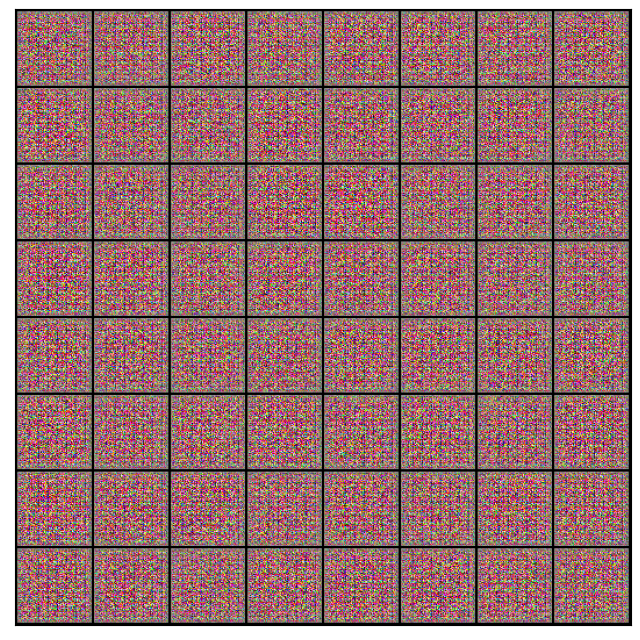

In [16]:
xb = torch.randn(batch_size, latent_size, 1,1)
fake_image = generator(xb)
print(fake_image.shape)
show_images(fake_image)

As one might expect, the output from the generator is basically random noise, since we haven't trained it yet .

In [17]:
generator = to_device(generator, device)

## Discriminator Training.

Since the discriminator is a binary classification model, we can use the binary cross entropy loss function to quantify how well it is able to differentiate between real and generated images.

### Binary cross Entropy

$$ - \frac{1}{N} \sum_{i=1}^N y_i \log(h_{\theta}(x_i)) + (1-y_i) \log(1-h_{\theta}(x_i))$$

In [18]:
def train_discriminator(real_image, opt_d):
    # clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_image)
    real_targets = torch.ones(real_image.size(0),1,device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1,1, device = device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device = device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()

    return loss.item(), real_score, fake_score


Here are the steps involved in training the discriminator.

1. We expect the discriminator to output 1 if the image was picked from the real MNIST dataset, and 0 if it was generated using the generator network.

2. We first pass a batch of real images, and compute the loss, setting the target labels to 1.

3. Then we pass a batch of fake images (generated using generator) pass them into the discriminator, and compute the loss, setting the target labels to 0.

4. Finally we add the two losses and use the overall loss to perform gradient descent to adjust the weights of the discriminator.

It's important to note that we don't change the weights of the generatr model while training the discriminator (`opt_d` only affects the `discriminator.parameters()`)

## Generator Training

Since the outputs of the generator are images, it's not obvious how we can train the generator. This is where we employ a rather elegant trick, which is to use the discriminator as a part of the loss function. Here's how it works:

1. We genereate a batch of images using the generator, pass them into the discriminator.

2. We calculate the loss by setting the target labels to 1 i.e., real. We do this because the generator's objective is to 'fool' the discriminator.

3. We use the loss to perform gradient descent i.e., change the weights of the generator, so it gets better at generating real-like images to 'fool' discriminator.


In [19]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1 , 1 , device = device)
    fake_images = generator(latent)

    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device= device)
    loss = F.binary_cross_entropy(preds, targets)

    # Update the generator weights
    loss.backward()
    opt_g.step()

    return loss.item()

Let's create a directory where we can save intermediate outputs from the generator to visually inspect the progress of the model. We'll also create a helper function to export the generated images.

In [20]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [21]:
def save_samples(index, latent_tensor, show= True):
    fake_images = generator(latent_tensor)
    fake_fname = 'generated-image-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname),nrow=8)
    print(f'Saving : {fake_fname}')
    if show:
        _,ax = plt.subplots(figsize=(8,8))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow = 8).permute(1,2,0))

We'll use a fixed set of input vectors to the generator to see how the individual generated images evolve over time as we train the model. Let's save one set of images before we start training our model.

In [22]:
fixed_latent = torch.randn(64, latent_size, 1 , 1 , device = device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving : generated-image-0000.png


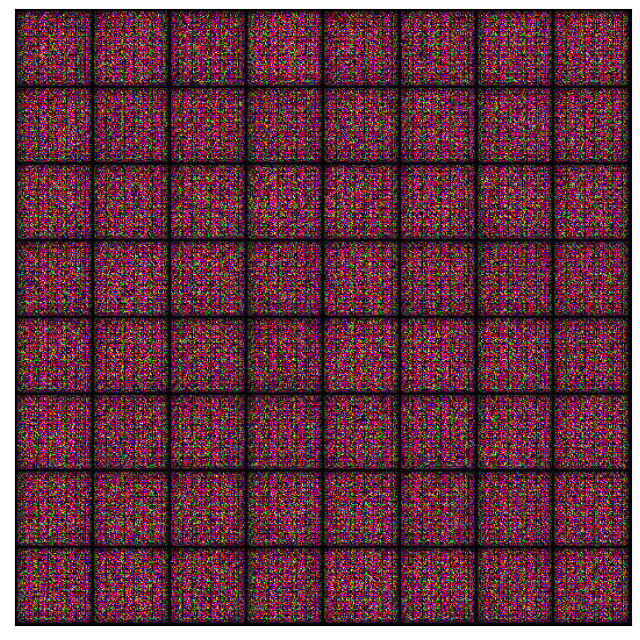

In [23]:
save_samples(0, fixed_latent)

## Full Training Loop

Let's defina a `fit` function to train the discriminator and generator in tandem for each batch of training data. We'll use the Adam optimizer with some custom parameters (betas) that are known to work well for GAN's. We will also save some sample generated images at regular intervals for inspection.

In [24]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()

    # Losses and scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr =lr, betas=(0.5,0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr =lr, betas=(0.5,0.999))

    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d , real_score, fake_score = train_discriminator(real_images, opt_d)

            # Train Generator
            loss_g = train_generator(opt_g)

        # Record losses and scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        # Log losses and scores
        print(f'Epoch [{epoch+1}/{epochs}], loss_g : {loss_g}, loss_d : {loss_d}, real_score : {real_score}, fake_score : {fake_score}')

        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)

    return losses_g,losses_d,real_scores, fake_scores

We are now ready to train the model. Try different learining rates to see if you can maintain the fine balance between the training the generator and the discriminator.

In [25]:
lr = 0.0002
epochs = 10

In [26]:
history = fit(epochs, lr)

  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [1/10], loss_g : 7.502670764923096, real_score : 0.8653509020805359, fake_score : 0.30665621161460876
Saving : generated-image-0001.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [2/10], loss_g : 4.625988960266113, real_score : 0.958587646484375, fake_score : 0.2578321695327759
Saving : generated-image-0002.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [3/10], loss_g : 4.672567367553711, real_score : 0.7702838182449341, fake_score : 0.026645144447684288
Saving : generated-image-0003.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [4/10], loss_g : 4.7620978355407715, real_score : 0.9114581942558289, fake_score : 0.07038276642560959
Saving : generated-image-0004.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [5/10], loss_g : 9.32384967803955, real_score : 0.7754523754119873, fake_score : 0.0005409743171185255
Saving : generated-image-0005.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [6/10], loss_g : 4.970705032348633, real_score : 0.900039792060852, fake_score : 0.02466844767332077
Saving : generated-image-0006.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [7/10], loss_g : 8.221237182617188, real_score : 0.8887795805931091, fake_score : 0.00040878119762055576
Saving : generated-image-0007.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [8/10], loss_g : 14.704894065856934, real_score : 0.9783616662025452, fake_score : 0.23707428574562073
Saving : generated-image-0008.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [9/10], loss_g : 5.84678316116333, real_score : 0.9428454041481018, fake_score : 0.05984655022621155
Saving : generated-image-0009.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [10/10], loss_g : 6.764413833618164, real_score : 0.971106767654419, fake_score : 0.08227648586034775
Saving : generated-image-0010.png


We can visualize the training process by combining the sample images generated after each epoch into a video using OpenCV.


In [28]:
vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'),1,(530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'avi / AVI (Audio Video Interleaved)'
OpenCV: FFMPEG: fallback to use tag 0x34504d46/'FMP4'


We can also visualize how the loss changes over time. Visualizing losses is quite useful for debugging the training process. For GAN's, we expect the genereator's loss to reduce over time, without the discriminator's loss getting too high

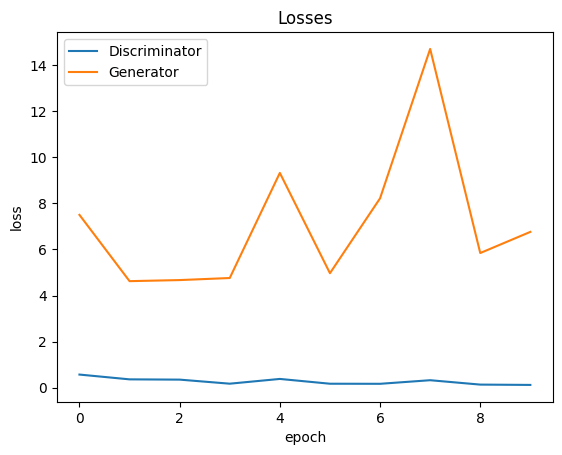

In [36]:
plt.plot(history[1],'-')
plt.plot(history[0],'-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator','Generator'])
plt.title("Losses");

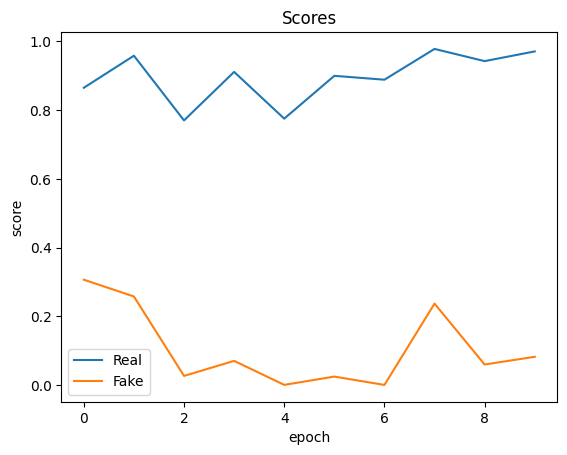

In [37]:
plt.plot(history[2],'-')
plt.plot(history[3],'-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real','Fake'])
plt.title("Scores");